# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [33]:
from sklearn.model_selection import train_test_split

X = df.drop(["salary", "salary_in_usd"], axis=1)
y = df["salary_in_usd"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=52)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']


for feature in categorical_features:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_train_enc = pd.DataFrame(encoder.fit_transform(X_train[[feature]]), columns=encoder.get_feature_names_out([feature]), index=X_train.index)
    X_val_enc = pd.DataFrame(encoder.transform(X_val[[feature]]), columns=encoder.get_feature_names_out([feature]), index=X_val.index)
    X_test_enc = pd.DataFrame(encoder.transform(X_test[[feature]]), columns=encoder.get_feature_names_out([feature]), index=X_test.index)
    
    X_train = pd.concat([X_train.drop(columns=[feature]), X_train_enc], axis=1)
    X_val = pd.concat([X_val.drop(columns=[feature]), X_val_enc], axis=1)
    X_test = pd.concat([X_test.drop(columns=[feature]), X_test_enc], axis=1)
    
    

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_test_preds = lin_reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_test_preds)
rmse = root_mean_squared_error(y_test, y_test_preds)

print('MAPE: ', round(mape, 2))
print('RMSE: ', round(rmse, 2))

MAPE:  30804749.8
RMSE:  14595779891438.34


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [41]:
import time

In [43]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

start = time.time()
params = {
    'max_depth': range(2, 10, 2),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 250, 500],
    'gamma': [0, 0.5, 1, 2]
}

xgb_reg = XGBRegressor()
xgb_search = GridSearchCV(estimator=xgb_reg, param_grid=params, cv=5, n_jobs=-1)
xgb_search.fit(X_val, y_val)
print("Время выполнения: {:.2f} секунд".format(time.time() - start))
print("Оптимальные гиперпараметры:", xgb_search.best_params_)

Время выполнения: 18.79 секунд
Оптимальные гиперпараметры: {'gamma': 0, 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100}


In [80]:
start = time.time()
y_test_preds = xgb_search.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_test_preds)
rmse = root_mean_squared_error(y_test, y_test_preds)
print("Время выполнения: {:.5} секунд".format(time.time() - start))

print('MAPE: ', round(mape, 4))
print('RMSE: ', round(rmse, 4))

Время выполнения: 0.02209 секунд
MAPE:  0.3482
RMSE:  51531.9793


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [49]:
from catboost import CatBoostRegressor

start = time.time()
params = {
    'depth': range(2, 10, 2),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'iterations': range(500, 2000, 500),
}


catboost_reg = CatBoostRegressor()
catboost_search = GridSearchCV(estimator=catboost_reg, param_grid=params, cv=5, n_jobs=-1)
catboost_search.fit(X_val, y_val, verbose=False)

print("Время выполнения: {:.2f} секунд".format(time.time() - start))
print("Оптимальные параметры:", catboost_search.best_params_)

Время выполнения: 15.09 секунд
Оптимальные параметры: {'depth': 6, 'iterations': 500, 'learning_rate': 0.05}


In [72]:
start = time.time()
y_test_preds = catboost_search.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_test_preds)
rmse = root_mean_squared_error(y_test, y_test_preds)
print("Время выполнения: {:.5f} секунд".format(time.time() - start))

print('MAPE: ', round(mape, 4))
print('RMSE: ', round(rmse, 2))

Время выполнения: 0.01343 секунд
MAPE:  0.381
RMSE:  51129.95


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [52]:
from sklearn.model_selection import train_test_split

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=52)
X_test_, X_val_, y_test_, y_val_ = train_test_split(X_test_, y_test_, test_size=0.5, random_state=52)

In [74]:
from catboost import Pool

train_pool = Pool(X_train_, y_train_, cat_features=categorical_features)
test_pool = Pool(X_test_, y_test_, cat_features=categorical_features)

start = time.time()
catboost_reg = CatBoostRegressor(depth=6, learning_rate=0.05, iterations=500, verbose=False)
catboost_reg.fit(train_pool)
print("Время выполнения: {:.2f} секунд".format(time.time() - start))

start = time.time()
y_test_preds = catboost_reg.predict(test_pool)
mape = mean_absolute_percentage_error(y_test_, y_test_preds)
rmse = root_mean_squared_error(y_test_, y_test_preds)
print("Время выполнения: {:.5f} секунд".format(time.time() - start))

print(f"MAPE: {round(mape, 4)}")
print(f"RMSE: {round(rmse, 2)}")

Время выполнения: 0.97 секунд
Время выполнения: 0.00131 секунд
MAPE: 0.3311
RMSE: 44687.37


**Ответ:** Качество по обоим метрикам улучшилось на ~15%. Также видна значительная прибавка в скорости выполнения: на 2 мс <=> в 2.5 раза уменьшилась. Да, однозначно стало лучше!

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [57]:
from lightgbm import LGBMRegressor

start = time.time()
params = {
    'max_depth': [2, 4, 8],
    'learning_rate': [0.01, 0.5, 0.1, 0.2],
    'n_estimators': [500, 1000, 2000],
}


lgbm_reg = LGBMRegressor(verbose=-1)
lgbm_search = GridSearchCV(estimator=lgbm_reg, param_grid=params, cv=5, n_jobs=-1, error_score='raise')
lgbm_search.fit(X_val, y_val)

print("Время выполнения: {:.2f} секунд".format(time.time() - start))
print("Оптимальные параметры:", lgbm_search.best_params_)

Время выполнения: 245.05 секунд
Оптимальные параметры: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 2000}


Оптимальные параметры: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 2000}

In [78]:
start = time.time()
y_test_preds = lgbm_search.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_test_preds)
rmse = root_mean_squared_error(y_test, y_test_preds)


print('MAPE: ', round(mape, 4))
print('RMSE: ', round(rmse, 2))
print("Время выполнения: {:.5f} секунд".format(time.time() - start))

MAPE:  0.3702
RMSE:  48053.64
Время выполнения: 0.01884 секунд


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** Лучшей по качеству оказалась модель CatBoost. Она имеет сравнительно низкие метрики MAPE и RMSE. LGBM-регрессор работает очень медленно и дает среднее качество, при том, что я уменьшил сетку гиперпараметров. CatBoost также очень хорош и по времени выполнения - всего 1 сек, когда XGB выполняет за 20 секунд. Таким образом, Catboost лучший во всех смыслах. Скорость предсказания везде одинаковая относительно погрешности 10^-2.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [2]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [3]:
ratings = ratings.T

Выкиньте строку под названием `user`.

In [4]:
ratings = ratings.drop(["user"])

In [5]:
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [6]:
ratings.fillna(0, inplace=True)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
pendulum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [7]:
import numpy as np

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(ratings)
labels = kmeans.labels_

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [9]:
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

print("Размеры кластеров:", cluster_sizes)

Размеры кластеров: {np.int32(0): np.int64(996), np.int32(1): np.int64(1), np.int32(2): np.int64(1), np.int32(3): np.int64(1), np.int32(4): np.int64(1)}


**Ответ:** Не особо полезная, так как почти все объекты принадлежат одному кластеру. Полагаю, что исполнители очень похожи, либо плохо подобран k.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [10]:
small_clusters = unique[counts == 1]
sep_artists = []

for cluster in small_clusters:
    name = ratings.index[labels == cluster][0]
    sep_artists.append(name)

print("Исполнители в кластерах размера 1:", sep_artists)

Исполнители в кластерах размера 1: ['the beatles', '\u200clinkin park', 'eno', 'the mountain goats']


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [11]:
listeners_share = pd.DataFrame((ratings > 0).mean(axis=1).sort_values(ascending=False).head(10), columns=["listeners_share"])
avg_listening_share = pd.DataFrame(ratings.where(ratings > 0).mean(axis=1).sort_values(ascending=False).head(10), columns=["avg_listening_share"])

print(listeners_share, '\n')
print(avg_listening_share, '\n')
print(f"The Beatles на {ratings.where(ratings > 0).mean(axis=1).sort_values(ascending=False).index.get_loc('the beatles') + 1} по средней доли прослушивания.")


                       listeners_share
the beatles                     0.3342
radiohead                       0.2778
deathcab for cutie              0.1862
coldplay                        0.1682
modest mouse                    0.1628
sufjan stevens                  0.1292
dylan. bob                      0.1262
red hot clili peppers           0.1258
pink fluid                      0.1256
kanye west                      0.1250 

                  avg_listening_share
日dir en grey                 0.165582
보아                           0.152327
cannibal corpse              0.109158
agalloch                     0.106110
michal w. smith              0.095254
stars of the lid             0.093198
ceremony                     0.089990
shpongle                     0.084345
dead can dance               0.084221
diana krall                  0.083468 

The Beatles на 92 по средней доли прослушивания.


**Ответ:** The Beatles с отрывом самая популярная группа по количеству уникальных слушателей, следующий артист отстает на 7%. Также на фоне остальных выделяется  Radiohead (по этой причине, именно они иногда попадают в отдельный кластер, а не The Beatles). Но при этом ливерпульская банда не входит даже в топ-50 по средней прослушиваемости, то есть слушатели несильно погружены в творчество группы. Можно сделать вывод, что Зе Битлз имеют очень высокий охват (например, из-за бэнгеров и очень популярных песен по типу Yesterday, Hey Jude, And I Love Her и др.), но большинство слушателей слушают именно хиты.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [12]:
from sklearn.preprocessing import normalize

strings = ratings.index.to_list()
ratings = pd.DataFrame(normalize(ratings), index=strings)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [13]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(ratings)
labels = kmeans.labels_

unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

print("Размеры кластеров:", cluster_sizes)

Размеры кластеров: {np.int32(0): np.int64(194), np.int32(1): np.int64(266), np.int32(2): np.int64(154), np.int32(3): np.int64(256), np.int32(4): np.int64(130)}


**Ответ:**  Однозначно кластеризация стала лучше. При некоторых random_state кластеры разбивают ~ сбалансированно.  Да, можем, так как кластеры стали более интерпретируемы.  

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [14]:
from scipy.spatial.distance import cosine


centroids = kmeans.cluster_centers_

dists = {}
for artist_idx, artist in enumerate(ratings.index):
    artist_vector = ratings.iloc[artist_idx].values
    cluster_distances = []
    
    for centroid in centroids:
        cluster_distances.append(1 - cosine(artist_vector, centroid))
    dists[artist] = cluster_distances


top_artists_per_cluster = {}
for cluster_id in range(5):
    sorted_artists = sorted(dists.items(), key=lambda item: item[1][cluster_id], reverse=True)
    top_artists = [artist for artist, dist in sorted_artists[:10]]
    top_artists_per_cluster[cluster_id] = top_artists

for cluster_num, artists in top_artists_per_cluster.items():
    print(f"Кластер №{cluster_num + 1} ({cluster_sizes[cluster_num]} артистов):")
    for i, artist in enumerate(artists):
        print(f"{i + 1}. {artist}")
    print()

Кластер №1 (194 артистов):
1. the beatles
2. coldplay
3. the rolling stones
4. dylan. bob
5. u2
6. counting crows
7. led zeppelin.
8. johnson jack
9. simon and garfunkel
10. john mayer

Кластер №2 (266 артистов):
1. a tribe called quest
2. nas
3. the roots featuring d'angelo
4. ￼beastie boys
5. gangstarr
6. niИ
7. jay-z
8. de la soul
9. metallica
10. ratm

Кластер №3 (154 артистов):
1. fall out boy
2. blink-182
3. brand new
4. taking back sunday
5. new found glory
6. saosin
7. the used
8. cartel
9. chiodos
10. paramore

Кластер №4 (256 артистов):
1. radiohead
2. the arcade fire
3. sufjan stevens
4. belle and sebastian
5. broken social scene
6. animal collective
7. the shins
8. of montreal
9. beirut
10. spoon

Кластер №5 (130 артистов):
1. rihanna & jay-z
2. kelly clarkson
3. the pussycat dolls
4. mariah carey
5. janet jackson.
6. alicia keys
7. beyoncé
8. justin timberlake
9. kanye west
10. lady gaga



**Ответ:** Не особо шарю в жанрах музыки, но чистым гуглингом пришел к:
* Пятый кластер явно содержин попсарей и r&b артистов конца нулевых - середины десятых годов.
* Второй кластер объединяет в себе рок-группы и хип-хоп коллективы.
* Третий содержит чисто рок-группы разных поджанров.
* Первый кластер наполовину состоит из классических рок-групп Британии. Наверное, американские рок-группы в списке находятся по тому же принципу.
* Четвертый кластер напрочь состоит из инди коллективов.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

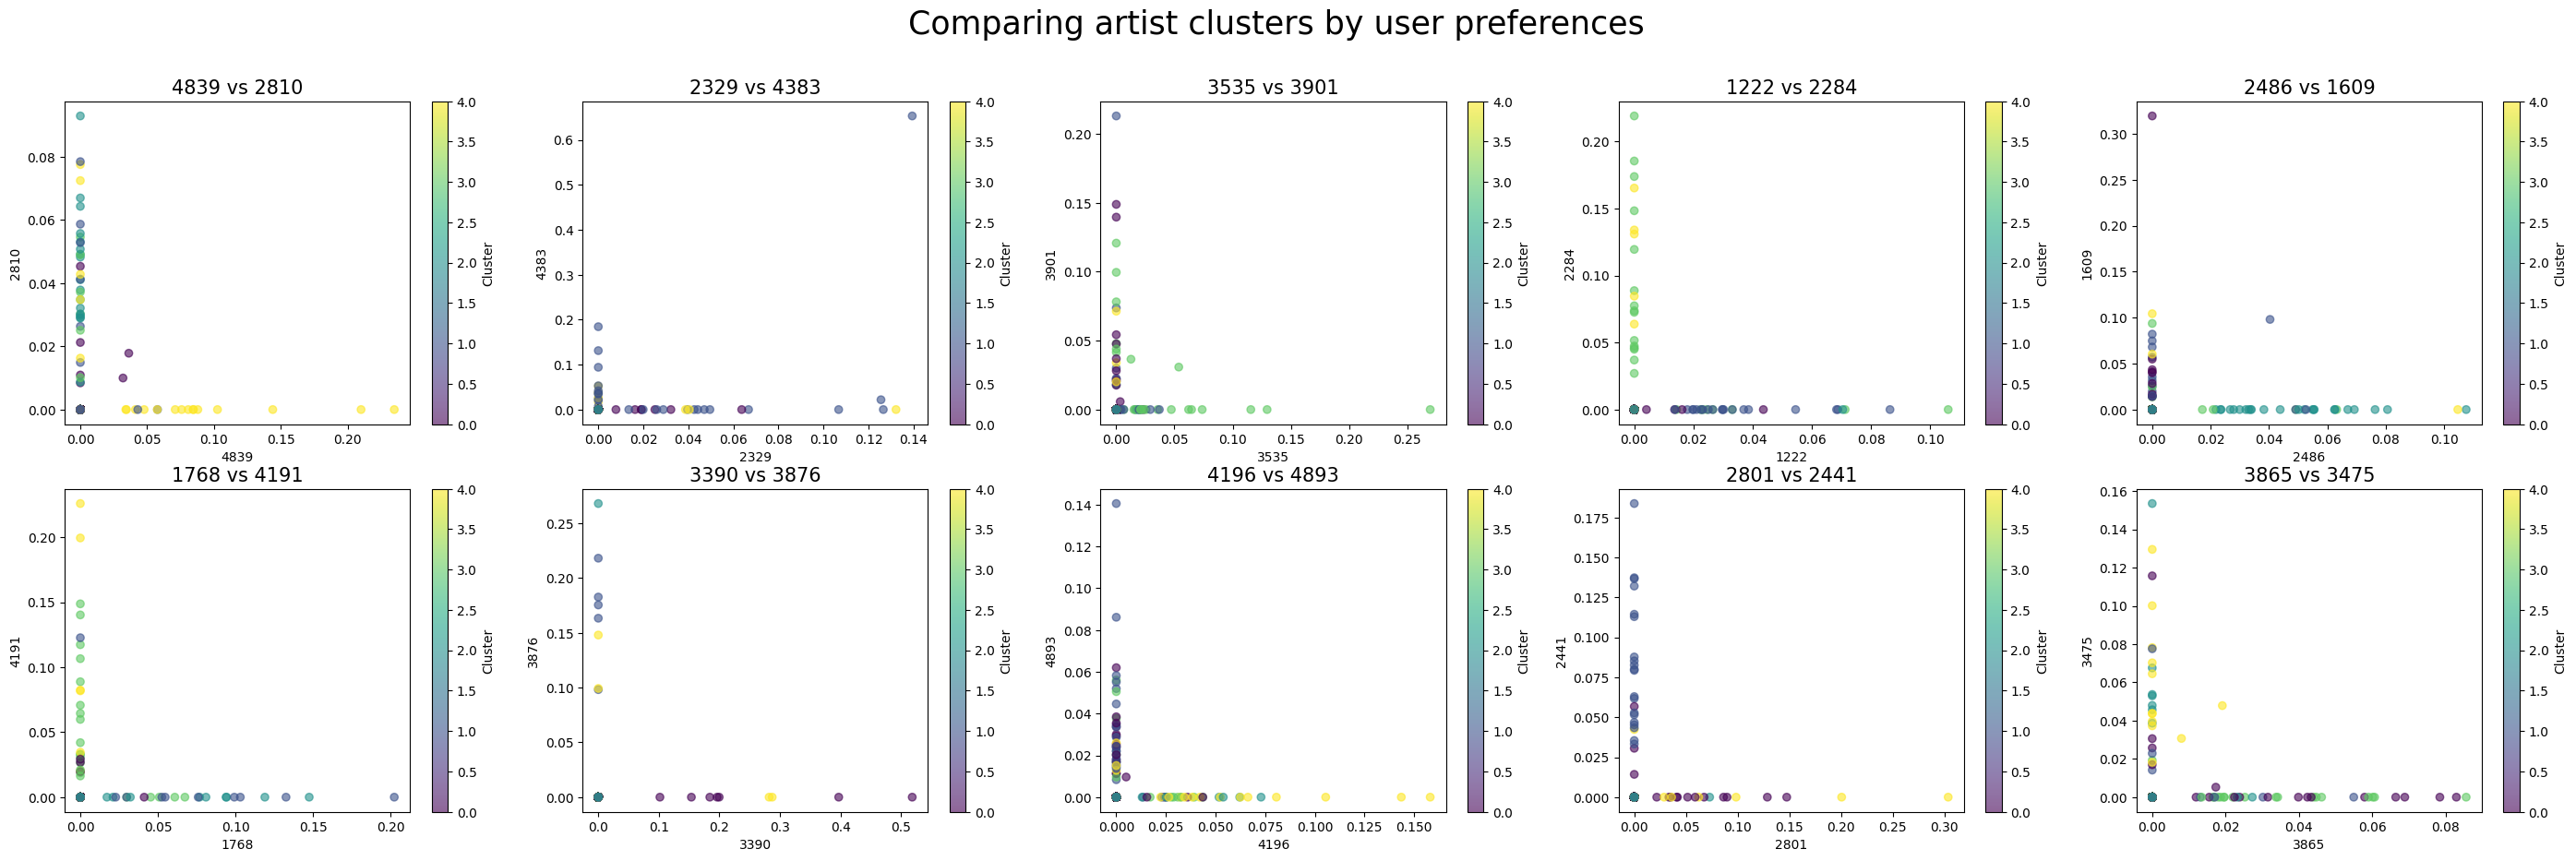

In [15]:
import matplotlib.pyplot as plt
from random import randint


def make_graphic(i, j, k, ax, labels):
    sc = ax.scatter(ratings.iloc[:, i], ratings.iloc[:, j], c=labels, cmap="viridis", alpha=0.6)
    
    ax.set_xlabel(i)
    ax.set_ylabel(j)
    ax.set_title(f'{i} vs {j}', fontsize=15)
    plt.colorbar(sc, ax=ax, label='Cluster')

fig, axes = plt.subplots(2, 5, figsize=(35, 10))
fig.suptitle('Comparing artist clusters by user preferences', fontsize=25)

for k in range(10):
    size = ratings.shape[1] - 1
    i, j = randint(0, size), randint(0, size)
    while i == j:
        j = randint(0, size)
        
    make_graphic(i, j, k, axes[k // 5, k % 5], labels)

**Ответ:** Изначально мы имеем пространство с 5000 осями, но сравнивая пару признаков исполнителей, мы ничего не можем понять.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

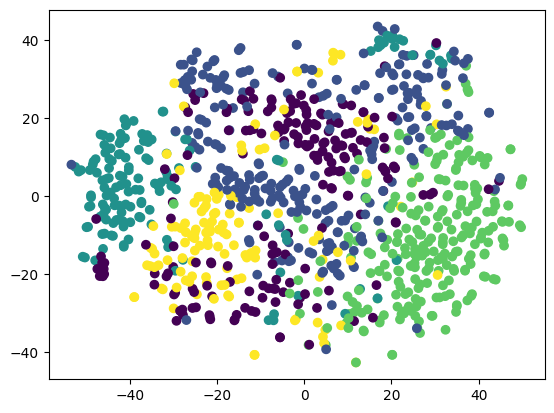

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(ratings)

plt.scatter(tsne[:, 0], tsne[:, 1], c=labels)
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [19]:
from sklearn.metrics import silhouette_score

best_k, best_score = None, -1
for k in [2, 3, 5, 7, 9, 15, 25, 51, 75, 99]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans = kmeans.fit(ratings)
    clusters = kmeans.predict(ratings)
    
    score = silhouette_score(X=ratings, labels=clusters)
    if score > best_score:
        best_k = k
        best_score = score
        
print(f'Kачество={np.round(best_score, 3)}, k={k}')

Kачество=0.013, k=99


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [20]:
centroids = kmeans.cluster_centers_

dists = {}
for artist_idx, artist in enumerate(ratings.index):
    artist_vector = ratings.iloc[artist_idx].values
    cluster_distances = []
    
    for centroid in centroids:
        cluster_distances.append(1 - cosine(artist_vector, centroid))
    dists[artist] = cluster_distances


top_artists_per_cluster = {}
for cluster_id in range(5):
    sorted_artists = sorted(dists.items(), key=lambda item: item[1][cluster_id], reverse=True)
    top_artists = [artist for artist, dist in sorted_artists[:10]]
    top_artists_per_cluster[cluster_id] = top_artists

for cluster_num, artists in top_artists_per_cluster.items():
    print(f"Кластер №{cluster_num + 1} ({cluster_sizes[cluster_num]} артистов):")
    for i, artist in enumerate(artists):
        print(f"{i + 1}. {artist}")
    print()

Кластер №1 (194 артистов):
1. dr. dre
2. the faint
3. violent femmes
4. margot and the nuclear so and sos
5. owen
6. the bloodhound gang
7. cursive
8. van hallen
9. bright eyes
10. ironand wine

Кластер №2 (266 артистов):
1. john mayer
2. matt nathanson
3. gavin degraw
4. jason mraz
5. ray lamontagne
6. joshua radin
7. sara bareilles
8. augustana
9. maroon5
10. o.a.r.

Кластер №3 (154 артистов):
1. white stripes
2. the raconteurs
3. beck
4. spoon
5. the strokes
6. cake
7. the flaming lips
8. black rebel motorcycle club
9. gorillaz
10. the black keys

Кластер №4 (256 артистов):
1. fugazi
2. jawbreaker
3. capn jazz
4. sleater-kinney
5. les savy fav
6. bad brains
7. propagandhi
8. gogol bordello
9. black flag
10. descendents

Кластер №5 (130 артистов):
1. ryan adams
2. band of horses
3. ryan adams and the cardinals
4. rogue wave
5. my morning jacket
6. matt pond pa
7. cloud cult
8. the american analog set
9. nada surf
10. tv on the radio



**Ответ:** Состав пяти ближайших к центроиду в каждом кластере изменился. Единственный кластер, который я смог нормально интепретировать - четвертый кластер: он состоит из пост-панк-хардкор-эмо групп. 

Сделайте t-SNE визуализацию полученной кластеризации.

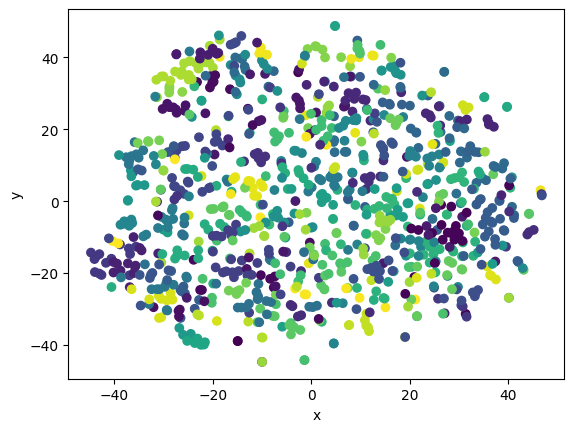

In [25]:
kmeans = KMeans(n_clusters=best_k).fit(ratings)
tsne = TSNE().fit_transform(ratings)
plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans.labels_)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

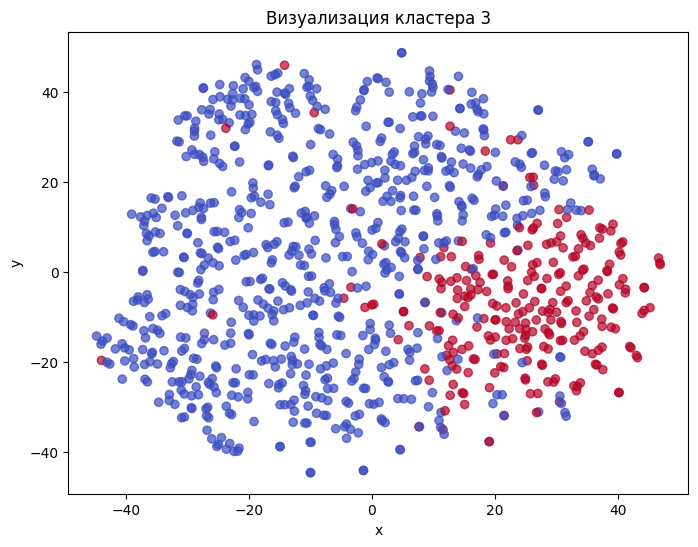

In [28]:
cluster_num = 3 
plt.figure(figsize=(8, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], c=(labels == cluster_num), cmap='coolwarm', alpha=0.7)
plt.title(f'Визуализация кластера {cluster_num}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Ответ:** Да, кластер 3 хорошо отражается. На графике видно, что точки, принадлежащие кластеру 3 формируют группу справа.
Остальные точки располагаются в другой части, и пересечение между кластерами малое, что говорит о хорошей разделимости кластеров.